In [2]:
using Gadfly
set_default_plot_size(20cm, 10cm)


## Links

- [WXtoImg](www.wxtoimg.com), sofware for APT and WEFAX transmission decoding. Contains a lot of other useful information
- [wavecom](http://www.wavecom.ch/content/ext/DecoderOnlineHelp/default.htm#!worddocuments/noaageosat.htm), sofware for decoding? Do research
- [NOAA-N Prime bookelet](http://www.osd.noaa.gov/Spacecraft%20Systems/Pollar_Orbiting_Sat/NOAA_N_Prime/NOAA_NP_Booklet.pdf), excellent technical overview of the NOAA-N Prime constellation
- [NOAA KLM Users Guide](https://www.ncdc.noaa.gov/oa/pod-guide/ncdc/docs/klm/index.htm), Primary source of technical information for the NOAA satellite constallation.

## Jargon

See the last appendix on the NOAA-N Prime booklet for a glossary

- POES - Polar orbiting satellites
- GOES - Geosychronous satellites


Currently operational satellites include NOAA-15, NOAA-18, NOAA-19, GOES 13, GOES 14, GOES 15, Jason-2 and DSCOVR.


**High Resolution on Picture Tranmission (HRPT)** - Provides worldwide direct readout of full-resolution spacecraft parameters and instrument data

**Automatic Picture Tranmission (APT)** - APT data is smoothed 4-km (2.5-mi)-resolution IR and visible imagery derived from the AVHRR/3 instrument. The Satellite Operations Control Center (SOCC) can select by command any two of the active five AVHRR/3 channels provided to the MIRP. 

The data is transmitted continuously over a dedicated VHF link as an analog signal consisting of an amplitude-modulated **2400-Hz subcarrier** frequency modulating the RF carrier at 137.1 MHz or 137.9125 MHz

**VHF beacon** - A lower data rate tranmission from the TIP. Can be received with less costly equipment. Data includes HIRS/4, SEM-2, ADCS, and SBUV/2, but not AMSU data. The beacon downlink frequency is either 137.35 MHz or 137.77 MHz

---

A 2247.5-MHz S-band downlink is used during satellite ascent to recover TIP
boost telemetry through Western Range (WR) tracking sites

# Satellite downlink frequencies

source: [sigidwiki](http://www.sigidwiki.com/wiki/Automatic_Picture_Transmission_%28APT%29), this is not a very trusworthy source

Satellite | Frequency [MHz] | Transmission type
----------|-----------------|------------------
NOAA-18   | 137.9125        | APT
NOAA-15   | 137.5000        | APT
NOAA 19   | 137.1000        | APT




# APT, Automatic Picture Transmission

source: NOAA KLM User's Guide, [Section 4.2 APT System](https://www.ncdc.noaa.gov/oa/pod-guide/ncdc/docs/klm/html/c4/sec4-2.htm)

> The processed AVHRR [Advanced Very High Resolution Radiometer] instrument data AM modulates a 2400 Hz subcarrier. The maximum subcarrier modulation is defined as the amplitude of the gray scale wedge number 8 (see Figure 4.2.2-1), producing a modulation index of 87% ±5% (not exceeding 92%). The AM modulated subcarrier is subsequently used to FM modulate the VTX transmitter operating in the 137 - 138 MHz band
- Line Rate: 	120 lines/min
- Data Channels: 	2 transmitted, 6 available
- Data Resolution: 	4.0 km
- Carrier Modulation: 	2.4 KHz AM subcarrier on FM carrier
- Transmitter Frequency (MHz): 	137.50 or 137.62
- Transmitter Power (EOL): 	5 W (37dBm)
- Radiated Power (dBm, @ 63 degrees): 	36.7
- Polarization: 	RCP

Each APT frame consists of 128 lines at 0.5 seconds per line. The tranmission time for a complete frame is $128 \times 0.5 \text{ s} = 64$ seconds.



# Link charasteristics


## Noise

source: RF Systems, Components, and Circuits; Section 6.2

The width of an APT transmission is 34 kHz in addition roughly 3 kHz of potential doppler shift in each direction due to the travelling speed of the satellite. The noise power for a single channel is (dBm)


In [25]:
T = 290;              # Noise teperature, kelvin
k = 138e-23;          # Boltsmann's constant, joule/kelvin
B = 34000 + 3000*2;   # channel width with padding for doppler, Hz
P_noise = k * T * B; 
println(10log(10, P_noise/0.001)) # power in dBm (single channel)
println(10log(10, k*T*1e6/0.001)) # 1 MHz (entire band)

-107.95662924371842
-93.97722915699808


## Free-Space loss

source: RF Systems, Components, and Circuits; Section 5.4

The **best-case** scenario for free-space loss is when the satellite is directly above the ground station. Worst case is when the satellite is just above the horizon. The horizon distance has been approximated with two different methods.

In [13]:
wavelength = 300e6/137.5e6 # meters
earth_radius = 6371e3      # meters

free_space_loss_db(range) = 10log(10, (4pi)^2 * range^2 / wavelength^2)

satellite_altitude = 850e3
horizon_range      = 4100 * sqrt(satellite_altitude)
geometric_range    = sqrt((earth_radius + satellite_altitude)^2 - earth_radius^2)

println(free_space_loss_db(satellite_altitude)) # best case
println(free_space_loss_db(horizon_range))      # worst case
println(free_space_loss_db(geometric_range))

133.79620466366015
146.75769254091193
145.83484906512712


In [24]:
radiated_power = 37  # dBm
println(radiated_power - free_space_loss_db(satellite_altitude))


-96.79620466366015


# Satellite orbits

source: NOAA KLM User's Guide, [Section 2.1 Navigating the Polar Satellite](https://www.ncdc.noaa.gov/oa/pod-guide/ncdc/docs/klm/html/c2/sec2-1.htm)
> The NOAA series of satellites have been placed in orbits with a mean height of about 850 kilometers (semi-major axis about 7228 kilometers). In order to be Sun synchronous, the inclination must then be about 99 degrees.

> Since, by Kepler's third law, the period is related to the semi-major axis, the period must be about 102 minutes

> The LST [Local Solar Time] of the ascending node is not constrained by any of these considerations, and is chosen for other reasons, mainly coverage. Power and thermal constraints preclude normal operation within two hours of noon LST. The times usually chosen are either an ascending (northbound) node around 1430 LST or a descending (southbound) node around 0730 LST.

The number of orbits per day can be calculated given the orbit period: 

In [19]:
orbit_period = 102*60 # seconds
orbits_per_day = 24*60*60 / orbit_period

14.117647058823529

This is not and even number, which means every time the the satellite passes, it will rise from a different direction in the horizon. This needs to be taken into account if the reception antenna is very directional.

---

The ground track of the satellite will move wastward a set amount with each orbit, and the optimal pass is not always in the same location:

In [20]:
ground_track_displacement = 360 / orbits_per_day
daily_track_displacement  = 360 % ground_track_displacement

println(ground_track_displacement) # degrees each orbit
println(daily_track_displacement ) # degrees each ~24 h

25.5
3.0


# Antenna Options

- **TODO:** how to determine the antenna load?
- **TODO:** how to design appropriate baulun?


The antenna should be fairly directional, preferably have a circular polarization, and be resonant at around 137.5 MHz.

In [8]:
c = 300e6;
downlink_freq = 137.5e6;
wavelength = c/downlink_freq

2.1818181818181817

## Axial-mode helix

This section is irrelevant. A custom antenna is probably going to be a quadfilar helix. This section is about a monofilat axial mode helix antenna.

---

The required turn spacing (meters) for a axial-mode helix, given the frequency criteria for the antenna is

In [9]:
spacing = wavelength/4

0.5454545454545454

and further, the diameter of the helix structure is

In [10]:
diameter = wavelength/pi

0.6944942971282705

The formula below for calculating directive gain is from wikipedia, but it does not state in reference to what the gain is? **OPEN:** Is it dBi? One would assume so. 

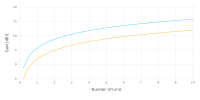

In [11]:
using Gadfly
turns = linspace(0,10);
circumference = wavelength; # in an optimal construction
directive_gain1 = turns * ( 15*((circumference^2 * spacing)/ wavelength^3)); # magic form wikipedia
directive_gain2 = turns * (6.2*((circumference^2 * spacing)/ wavelength^3)); # magic from antenna-theory
plot(
layer(y=10 *log(10,directive_gain1), x=turns, Geom.line),
layer(y=10 *log(10,directive_gain2), x=turns, Geom.line, Theme(default_color=colorant"orange")),
Guide.ylabel("Gain [dBi]"), Guide.xlabel("Number of turns"), Stat.xticks(ticks=collect(0:1:10))
)

The graph below shows how the directionality of a helical antenna is dependent on the number of turns in the helix. Using more than three turn has little effect on the beam width, altough the gain of the primary lobe will still increase meaningfully past three turns.

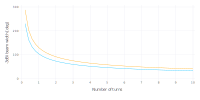

In [12]:
using Gadfly
HPBW1 = (52 * wavelength^(3/2))./(wavelength* sqrt(turns * spacing)) # magic from wikipedia
HPBW2 = (65 * wavelength)./(circumference* sqrt((turns * spacing)/wavelength)) # magic from antenna-theory
plot(
layer(y=HPBW1, x=turns, Geom.line),
layer(y=HPBW2, x=turns, Geom.line, Theme(default_color=colorant"orange")),
Guide.xlabel("Number of turns"), Guide.ylabel("-3dBi beam width [deg]"), Stat.xticks(ticks=collect(0:1:10))
)

## Quadrifilar helix

Sometimes also referred to as *quadrifilar helicoid* or *QFH*. The wxtoimg website recommends reveral QFH antennas on their [hardware page](http://www.wxtoimg.com/hardware/). Some build instructions can be found [here](http://www.qsl.net/kf4cpj/qha/) and some links [here](http://jcoppens.com/ant/qfh/index.en.php)

The QFH antenna is **not** directional, but radiates fairly evenly to the northern hemisphere. The polarization is circular. This allows recepition without having to track the satellite while it is passing.


### Building parameters

source: http://jcoppens.com/ant/qfh/index.en.php

These parameter are for a quadfilar helix on 137.5 MHz with a quarter rotation of twist

Large loop parameter				|length
------------------------------------|----------
Total length						|2365 mm
Vertical separator					|871.3 mm
Total compensated length			|2373.6 mm
Compensated vertical separation		|861.3 mm
Antenna height H1 					|716.8 mm
Internal diameter Di1 				|313.9 mm
Horizontal separator D1 			|315.4 mm
Compensated horiz. separation Dc1	|305.4 mm 



Short loop parameter				|length
------------------------------------|----------
Total length						|2247.4 mm
Vertical tube						|828.2 mm
Compensated total length 			|2256 mm
Compensated vertical tube 			|818.2 mm
Antenna height H2	 				|681.3 mm
Internal diameter Di2	 			|298.2 mm
Horizontal separator D2 			|299.7 mm
Compensated horiz. separator Dc2	|289.7 mm 

## Turnstile antenna

A turnsitile antenna consists of a pair of crossed dipoles. The 

# The RF bandpass filter



- **TODO**: this entire section is difficult to read, don't abuse the jupyter notebook features.



- **NOTE:** The manual design in this section is deprecated. **See AWR simulations for complete circuits and analysis**.
- **TODO:** where is the bandpass filter? Should it match to 50 ohms on both input and ouput, or can it be between the antenna and the coax line, ie. the input matches the antenna impedance? **CLOSED:** match 50 in and out.

An RF bandpass filter is used in order to avoid overdriving the input circuits on the receiver. At 138 MHz there are phenomena, such as component self-resonance that need to be taken into account.

The maximum and minimum downlink frequencies of the different satellites are 137.9125 MHz and 137.1000 MHz respectively. The downlink RF bandwidth is 34 kHz and the worst-case doppler shift is approximately 3kHz. 



In [13]:
min_freq = 137.1000e6; # values are in Hz
max_freq = 137.9125e6;
downlink_bandwidth = 34e3;
doppler_shift = 3e3;

# For a minimal bandpass filter, these parameters would give a center frequency of
passband_center = sqrt(min_freq * max_freq) # Hz

#and further a passband width of
passband_width = max_freq - min_freq + 2*doppler_shift + downlink_bandwidth # Hz

# The Finnish Communication Regulatory Authority allocates a
#1 MHz band between 137.000 MHz and 138 MHz for meteorological
#satellite downlinks. This is also a good target specification
#for the bandpass filter. This would give a passband width of
#exactly 1 MHz and a center frequency of
passband_center = sqrt(137e6*138e6) # Hz

Q_filter = passband_center / passband_width

## A resonant LC circuit

In [18]:
function parallel(values)
    sum(1./values)^-1 # inverted sum of the inverted values
end
R_load = 50;
R_source = 50;
Q_loaded = Q_filter;
freq_resonant = passband_center;
R_parallel = parallel([R_load,R_source]);
X_parallel = R_parallel / Q_loaded
L = X_parallel / (2 *pi * freq_resonant)


1.7941339916672056e-10

### Capacitor self-resonance

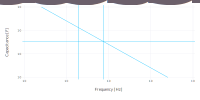

In [83]:
using Gadfly
L = 10e-9 # inductance of the leads
capacitance = 10 .^ linspace(-9, -12) # capacitance of the capacitor
freq_self_resonance  = 1./(2*pi*sqrt(L * capacitance)) # self-resonant frequency as a function of capcitance
freq_target = 137.5e6 
freq_treshold = freq_target * 2
capacitance_max = 1/((2*pi*freq_treshold)^2 * L) # maximum value where capacitor behaviour is normal

plot(
x=freq_self_resonance, y=capacitance, Geom.line, Scale.x_log10, Scale.y_log10,
Guide.xlabel("Frequency [Hz]"), Guide.ylabel("Capacitance [F]"),
xintercept=[freq_target, freq_treshold  ], Geom.vline, 
yintercept=[capacitance_max]             , Geom.hline
)

In [3]:
freq_target = 137.5 ; freq_treshold = 137.5*2
L_lead = 10e-9
capacitance_max = 1/((2*pi*freq_treshold)^2 * L_lead)

# the inductance of the coil is chosen based on the maximum capacitance that can used
L_1 = 1/((2 * pi * freq_target)^2 * capacitance_max) # inductance of the coil
X_p = 100e-9 * 2 * pi * freq_target # X_p parallel reactance

C_ratio = 9.81 # C_1 / C_2 ratio of tapping capacitors

9.81

## Capacitance tapped circuit

See *RF Circuit Design* by *Bowick.C* for references.

The band pass filter is a C-tapped prallel LC circuit

---


The starting point of the design are the following parameters


In [4]:
L = 100e-9 # inductance of the coil, Henry
BW = 1e6 # bandwidth of the filter, Hertz
f_c = 137.5e6 # center frequency of the filter, Hertz

1.375e8

At the resonant frequency, this inductance value gives us a an impedance of

In [6]:
X_p = L * 2 * pi * f_c # impedance of the inductor at resonant frequency

86.39379797371932

The Q of the inductor has to be at least as high as the desired Q for the circuit

In [11]:
Q_circuit = f_c / BW # the Q value the circuit needs to fill the design specification
Q_ind = Q_circuit

137.5

The minimum shunt resistance of the inductor can be determined given the impedance and the constraint that the inductor Q value need to be higher than the circuit Q.

In [9]:
R_p = Q_ind * X_p # the minimum required shut resistance of the inductor 

11879.147221386405

The corresponding equivalent series resistance can be determined given the minimim shunt resistance. This value need to be taken into account when planning how to wind the inductor.

In [12]:
R_s = R_p / (Q_ind^2 + 1) # the maximum resistance of the inductor coil

0.6282852990988328

The requred capacitor value of the a simple parallel LC resonator can be determined given the specified inductor value and resonant frequency.

In [13]:
C = 1 / ((2*pi*f_c)^2 * L)

1.3397842465102517e-11


## High-Q inductor

source: Christopher Bowick; Davin Knight

The inductor for the band pass filter is custom built. These are some things to take into account:

- Reduce **skin effect** by using wire with a larger diameter.
- Reduce **proximity effect** by winding the coil with a longer spacing between turns.
- Reduce **dielectric losses** eg. by suspending the coil in mid-air.
- Avoid making the inductor self-resonant. **OPEN:** How to determine paracitic capacitance?

---

Below is a piece of code intended to be used to get a feel for what value inductors are feasible to build. It's not an amazing tool, but playing around with it can be useful

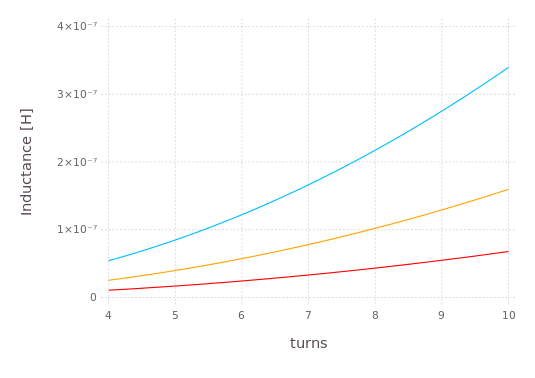

In [1]:
using Gadfly
#length = linspace(0.01,0.06);
length = [2.35e-3, 5e-2]
diameter = length;

function inductance(turns, length, diameter)
    permeability = pi * 4e-7;
    area = diameter.^2 * pi / 4;
    radius = diameter/2
    #return permeability * (turns.^2) .* area ./ length;
    return 1e-6 * (0.394 * (radius).^2 * turns.^2) ./ (9 * radius/10 + 10 * length/10)
end

#high_q1 = inductance(7, length, diameter)
#high_q2 = inductance(8, length, diameter)
#high_q3 = inductance(9, length, diameter)

turns = linspace(4,10)
large = inductance(turns, 5e-2, 5e-2)
smaller = inductance(turns, 2.35e-2, 2.35e-2)
even_smaller = inductance(turns, 1e-2, 1e-2)


plot(
layer(y=large, x=turns,Geom.line),
layer(y=smaller, x=turns,Geom.line, Theme(default_color=colorant"orange")),
layer(y=even_smaller, x=turns,Geom.line, Theme(default_color=colorant"red")),

Guide.ylabel("Inductance [H]"), Guide.xlabel("turns")
)

# Doppler shift

Since orbiting satellites move fast relative to the ground station, the actual percieved downlink frequency will not stay constant during a satellite pass due to the doppler effect.

The NOAA satellites travel at roughly 7400 m/s. The graph below shows that that speed could cause shift of more than 3 kHZ. In practice the satellite will never travel directly toward the ground station, therefore the doppler shifts will probably be smaller. The relative velocity of a satellite is zero when it is at the middle of passing the ground station.

A 3 kHz shift in frequency should not cause any problems on the RF side of the system; the filters are not that selective, and tracking carrier drift is something that recievers have deal with for a long time.

---

Below is a plot of the doppler shif of the carrier as a function of the satellite's relative velocity to the ground station.

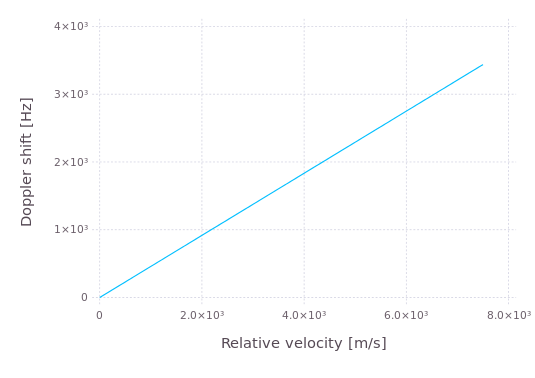

In [1]:
using Gadfly
c = 300e6
downlink_freq = 137.5e6
relative_velocity = linspace(1,7500);
doppler_shift = (c./(c + relative_velocity)) * downlink_freq - downlink_freq;

plot(
    x=relative_velocity, y=-doppler_shift, Geom.line,
    Guide.xlabel("Relative velocity [m/s]"), Guide.ylabel("Doppler shift [Hz]")
)

# RTL-SDR

## Calibration curves

Below are the calibration curves for the RTL-SDR dongle when used together with Gqrx. The curves were generated by supplying a 137.5 MHz sine wave from a (**TODO:** what model?) RF signal generator.

Original data is in the [rtl-sensitivity-measurements](./rtl-sensitivity-measurements) directory of this repository in the form of screenshots.

Below the first column is the signal-level set in the generator [dBm], the second column is the signal-level [dBFS] reported by gqrx when the LNA is set to 0dB, and the third column is the signal-level when the LNA is set to 49 dB.

There are no datapoints for reference signal values less than -100 dBm, because the signal was below the noise floor of the receiver. 

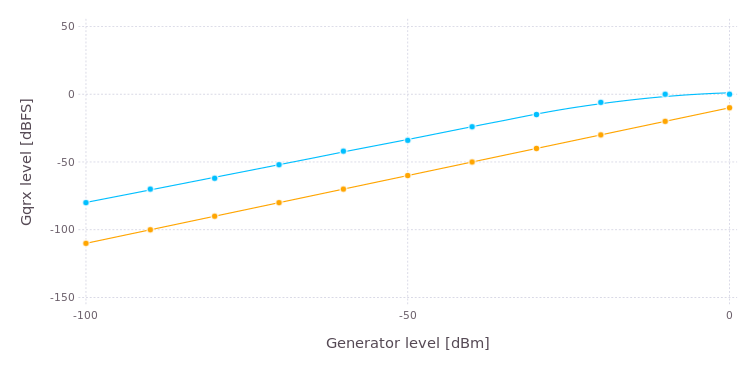

In [5]:
using Gadfly
set_default_plot_size(20cm, 10cm)

# Columns: reference, LNA 0dB scale, LNA 49dB scale 
datapoints = [
 -0  -0  -10;
-10  -0  -20;
-20  -6  -30;
-30  -15 -40;
-40  -24 -50;
-50  -34 -60;
-60  -42 -70;
-70  -52 -80;
-80  -62 -90;
-90  -70 -100;
-100 -80 -110;
]
len = Int(length(datapoints)/3)
reference = datapoints[1:len]
gqrx_lna_00dB = datapoints[1+len:2*len]
gqrx_lna_49dB = datapoints[1+2*len:3*len]


plot( 
layer(x= reference, y = gqrx_lna_00dB, Geom.point, Geom.smooth),
layer(x= reference, y = gqrx_lna_49dB, Geom.point, Geom.smooth, Theme(default_color=colorant"orange")),

Guide.xlabel("Generator level [dBm]"), Guide.ylabel("Gqrx level [dBFS]")
)


# Antenna comparison data

data collected in the comarison test on 2016-03-16, [./projeclog.ipynb#2016-03-16](#2016-03-16)

In [1]:
import numpy
# The gqrx LNA gain was set to 17 in these measurements
data = [
    [-52,-55,-57,-56],      # horzontal_dipole
    [-40,-36,-35,-39],      # vertical_dipole
    [-45,-50,-42,-45],      # horizonta_monopole
    [-43,-40,-37,-41],      # vertical_monopole
    [-52,-54,-50,-51],      # horizontal_logperiodic
    [-51,-51,-51,-52],      # vertival_logperiodic
]

print "antenna |min | max | mean"
print "--------|----|-----|-----"
print "horzontal dipole   |", numpy.min(data[0]), "|", numpy.max(data[0]), "|", numpy.mean(data[0])
print "vertical dipole    |", numpy.min(data[1]), "|", numpy.max(data[1]), "|", numpy.mean(data[1])
print "horizonta monopole |", numpy.min(data[2]), "|", numpy.max(data[2]), "|", numpy.mean(data[2])
print "vertical monopole  |", numpy.min(data[3]), "|", numpy.max(data[3]), "|", numpy.mean(data[3])
print "horizontal logperiodic |", numpy.min(data[4]), "|", numpy.max(data[4]), "|", numpy.mean(data[4])
print "vertival logperiodic |", numpy.min(data[5]), "|", numpy.max(data[5]), "|", numpy.mean(data[5])



antenna |min | max | mean
--------|----|-----|-----
horzontal dipole   | -57 | -52 | -55.0
vertical dipole    | -40 | -35 | -37.5
horizonta monopole | -50 | -42 | -45.5
vertical monopole  | -43 | -37 | -40.25
horizontal logperiodic | -54 | -50 | -51.75
vertival logperiodic | -52 | -51 | -51.25


# APT subcarrier drift data (from baudline)

analysis in documented in the projectlog notebook entry for [2016-04-02](./projectlog.ipynb#2016-04-02). These points were collected using baduline's *primary Hz* measurement tool. 

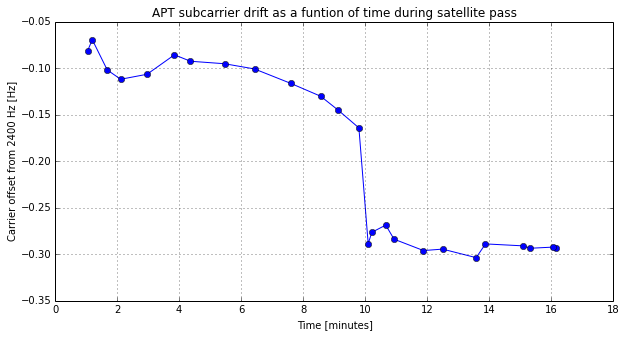

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# col0: .wav file timestamp [ms]
# col1: subcarrier frequency [Hz]
data = [
[970592, 2399.706309],
[963676, 2399.707717],
[920658, 2399.7065],
[906048, 2399.709074],
[833821, 2399.71118],
[815380, 2399.696399],
[750836, 2399.705571],
[713954, 2399.704030],
[656326, 2399.716274],
[640969, 2399.731391],
[613297, 2399.723667],
[606382, 2399.711343],
[588709, 2399.835944],
[548754, 2399.854965],
[514945, 2399.869956],
[456922, 2399.883820],
[386627, 2399.899299],
[328999, 2399.904905],
[262150, 2399.907589],
[231415, 2399.914501],
[178397, 2399.893583],
[127684, 2399.888215], 
[101560, 2399.898178],
[72361,  2399.930738],
[63141,  2399.918900],
]

plt.figure(figsize=(10,5))
plt.plot([row[0]/1000/60.0 for row in data] , [row[1]- 2400 for row in data], '-o')
plt.title("APT subcarrier drift as a funtion of time during satellite pass")
plt.xlabel("Time [minutes]")
plt.ylabel("Carrier offset from 2400 Hz [Hz]")
plt.grid()
plt.savefig("./photos/subcarrier-drift-as-function-of-time.png")
plt.show()




# Sources

- NOAA, NOAA-N Prime, The final TIROS mission
- Bowick, C. RF Circuit Design
- Boylestad, R.L. Introuctory Circuit Analysis
- BoeingGOES N Data Book
- RF systems, components, and circuits, Ferril A. Losee
- NOAA KLM USER'S GUIDE Section 4.2 APT System
- Componets And Materials, David Knight
- Antennas, John D. Kraus
- Modern Antenna Design, Thomas A. Milligan
- NOAA 2009. User's Guide for Building and Operating Environmental Satellite Receiving Stations

## blogs/internet sources

many of the early sources were not documented

More reliable sources:
- [Future NOAA Polar Orbiting and Geostationary Satellite Systems, NOAA Satellite informations systems](http://noaasis.noaa.gov/NOAASIS/ml/future.html)

less reliable: 
- http://www.oz9aec.net/index.php/gnu-radio-blog/477-noaa-apt-reception-with-gqrx-and-rtlsdr
- http://www.jpole-antenna.com/2012/07/03/why-build-antennas-out-of-copper-and-not-aluminum-or-stainless-steel/


## Software

- Atpdec http://atpdec.sourceforge.net/index.html
- Gpredict http://gpredict.oz9aec.net/